Pipelines: Light Parametric + Mass Total + Source Parametric
============================================================

By chaining together three searches this script fits strong lens `Imaging`, where in the final model:

 - The lens galaxy's light is a parametric `EllSersic`.
 - The lens galaxy's total mass distribution is an `EllPowerLaw`.
 - The source galaxy is a parametric `EllSersic`.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autofit as af
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


__Dataset + Masking__ 

Load, plot and mask the `Imaging` data.

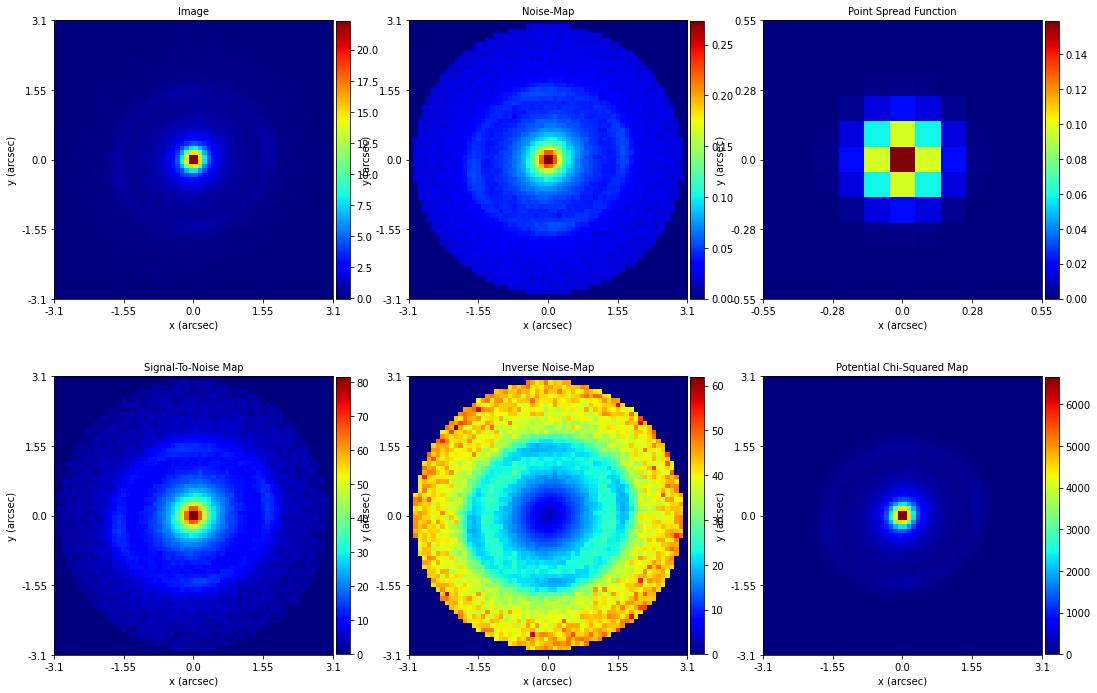

In [2]:
dataset_name = "light_sersic__mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "with_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=3.0
)

imaging = imaging.apply_mask(mask=mask)

imaging_plotter = aplt.ImagingPlotter(imaging=imaging)
imaging_plotter.subplot_imaging()

__Paths__

The path the results of all chained searches are output:

In [3]:
path_prefix = path.join("imaging", "pipelines")

__Redshifts__

The redshifts of the lens and source galaxies, which are used to perform unit converions of the model and data (e.g. 
from arc-seconds to kiloparsecs, masses to solar masses, etc.).

In [4]:
redshift_lens = 0.5
redshift_source = 1.0

__Model + Search + Analysis + Model-Fit (Search 1)__

In search 1 we fit a lens model where:

 - The lens galaxy's light is a parametric `EllSersic` bulge [7 parameters].
 
 - The lens galaxy's mass and source galaxy are omitted.

The number of free parameters and therefore the dimensionality of non-linear parameter space is N=7.

In [5]:
model = af.Collection(
    galaxies=af.Collection(
        lens=af.Model(al.Galaxy, redshift=0.5, bulge=af.Model(al.lp.EllSersic))
    )
)

search = af.DynestyStatic(
    path_prefix=path_prefix,
    name="search[1]_light[parametric]",
    unique_tag=dataset_name,
    nlive=50,
)

analysis = al.AnalysisImaging(dataset=imaging)

result_1 = search.fit(model=model, analysis=analysis)

2021-05-10 14:55:48,838 - root - INFO - No Dynesty samples found, beginning new non-linear search. 
2it [00:00,  8.27it/s, +50 | bound: 0 | nc: 1 | ncall: 52 | eff(%): 100.000 | loglstar:   -inf < -2414.210 <    inf | logz: -2418.875 +/-    nan | dlogz:  1.099 >  0.059]
2021-05-10 14:55:49,100 - root - INFO - 5000 Iterations: Performing update (Visualization, outputting samples, etc.).
2021-05-10 14:55:49,153 - root - INFO - 10000 Iterations: Performing update (Visualization, outputting samples, etc.).
2021-05-10 14:55:49,191 - root - INFO - 15000 Iterations: Performing update (Visualization, outputting samples, etc.).


__Model + Search + Analysis + Model-Fit (Search 2)__

In search 2 we fit a lens model where:

 - The lens galaxy's light is an `EllSersic` bulge [Parameters fixed to results of search 1].
 
 - The lens galaxy's total mass distribution is an `EllIsothermal` with `ExternalShear` [7 parameters].
 
 - The source galaxy's light is a parametric `EllSersic` [7 parameters].

The number of free parameters and therefore the dimensionality of non-linear parameter space is N=14.

In [6]:
model = af.Collection(
    galaxies=af.Collection(
        lens=af.Model(
            al.Galaxy,
            redshift=redshift_lens,
            bulge=result_1.instance.galaxies.lens.bulge,
            mass=al.mp.EllIsothermal,
            shear=al.mp.ExternalShear,
        ),
        source=af.Model(al.Galaxy, redshift=redshift_source, bulge=al.lp.EllSersic),
    )
)

search = af.DynestyStatic(
    path_prefix=path_prefix,
    name="search[2]_light[fixed]_mass[sie]_source[parametric]",
    unique_tag=dataset_name,
    nlive=75,
)

analysis = al.AnalysisImaging(dataset=imaging)

result_2 = search.fit(model=model, analysis=analysis)

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/dynesty/dynesty.py:390: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
2021-05-10 14:55:49,780 - root - INFO - No Dynesty samples found, beginning new non-linear search. 
2it [00:00, 85.80it/s, +75 | bound: 0 | nc: 1 | ncall: 77 | eff(%): 100.000 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:  1.099 >  0.084]
2021-05-10 14:55:49,830 - root - INFO - 5000 Iterations: Performing update (Visualization, outputting samples, etc.).
2021-05-10 14:55:50,097 - root - INFO - 10000 Iterations: Performing update (Visualization, outputting samples, etc.).
2021-05-10 14:55:50,295 - root - INFO - 15000 Iterations: Performing update (Visualization, outputting samples, etc.).


__Model + Search + Analysis + Model-Fit (Search 3)__

In search 2 we fit a lens model where:

 - The lens galaxy's light is an `EllSersic` bulge [7 Parameters: we do not use the results of search 1 to 
 initialize priors].
 
 - The lens galaxy's total mass distribution is an `EllIsothermal` with `ExternalShear` [7 parameters: priors
 initalized from search 2].
 
 - The source galaxy's light is a parametric `EllSersic` [7 parameters: priors initalized from search 2].

The number of free parameters and therefore the dimensionality of non-linear parameter space is N=25.

The result of search 1 is sufficient for subtracting the lens light, so that search 2 can accurately fit the lens
mass model and source light. However, the lens light model may not be particularly accurate, so we opt not to use
the result of search 1 to initialize the priors.

In [7]:
model = af.Collection(
    galaxies=af.Collection(
        lens=af.Model(
            al.Galaxy,
            redshift=redshift_lens,
            bulge=af.Model(al.lp.EllSersic),
            mass=result_2.model.galaxies.lens.mass,
            shear=result_2.model.galaxies.lens.shear,
        ),
        source=af.Model(
            al.Galaxy,
            redshift=redshift_source,
            bulge=result_2.model.galaxies.source.bulge,
        ),
    )
)

search = af.DynestyStatic(
    path_prefix=path_prefix,
    name="search[3]_light[parametric]_mass[total]_source[parametric]",
    unique_tag=dataset_name,
    nlive=100,
)

analysis = al.AnalysisImaging(dataset=imaging)

result_3 = search.fit(model=model, analysis=analysis)


/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/dynesty/dynesty.py:390: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
2021-05-10 14:55:51,290 - root - INFO - No Dynesty samples found, beginning new non-linear search. 
2it [00:00, 118.99it/s, +100 | bound: 0 | nc: 1 | ncall: 102 | eff(%): 100.000 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:  1.099 >  0.109]
2021-05-10 14:55:51,327 - root - INFO - 5000 Iterations: Performing update (Visualization, outputting samples, etc.).
2021-05-10 14:55:51,569 - root - INFO - 10000 Iterations: Performing update (Visualization, outputting samples, etc.).
2021-05-10 14:55:51,790 - root - INFO - 15000 Iterations: Performing update (Visualization, outputting samples, etc.).
